In [1]:
import matplotlib.pyplot as plt
import shutil, os, math, time
from glob import glob
from tqdm import tqdm
import skimage.io as io
from skimage.transform import rescale, resize
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, metrics

In [2]:
try:
  import deepface
except:
  !pip -q install deepface

try:
  import mediapipe
except:
  !pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 48.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.21 which is incompatible.


## Data preperation

In [3]:
from zipfile import ZipFile
file_name = '/content/temp_data.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall("Data")
  print('Done')

Done


In [4]:
DEST_DIR = './Data'
no_of_images={}
for dir in os.listdir("./Data"):
  no_of_images[dir]=len(os.listdir(os.path.join(DEST_DIR,dir)))
no_of_images

{'Tom Hiddleston': 181,
 'Taylor Swift': 131,
 'Alvaro Morte': 139,
 'Zendaya': 138,
 'Chris Evans': 166}

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded


Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /root/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2
100%|██████████| 5.71M/5.71M [00:02<00:00, 1.99MB/s]


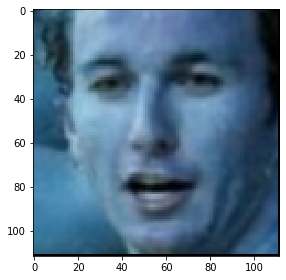

In [5]:
from utils import face_extract, pair_verify

io.imshow(face_extract("3.jpg"))

In [6]:
%%time
from matplotlib.image import imsave

def dataFolder(p, split):
    if not os.path.exists("./Model_Data"):
        os.mkdir("./Model_Data")
    if not os.path.exists("./Model_Data/"+p):
        os.mkdir("./Model_Data/"+p)
        for dir in os.listdir(DEST_DIR):
            os.makedirs("./Model_Data/"+p+"/"+dir)
            for img in np.random.choice(a=os.listdir(os.path.join(DEST_DIR,dir)), size = (math.floor(split*no_of_images[dir])-5),replace=False):
                O = os.path.join(DEST_DIR,dir,img)
                if p in ("Train","Val"):
                    img_array = face_extract(O)
                    imsave("./Model_Data/"+p+"/"+dir+"/"+img, img_array)
                else:
                    D = os.path.join("./Model_Data/"+p,dir)
                    shutil.copy(O,D)
    else:
        print(f"{p} Exists")

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 17.6 µs


In [7]:
dataFolder("Train",0.7)
dataFolder("Val",0.3)
dataFolder("Test",0.5)

In [8]:
#!rm -r Model_Data

## pretrained model

In [9]:
from ArcFace import loadModel

In [10]:
def get_new_model():
  """ Returns the ArcFace model with last few lasyer trainable """
  model = loadModel()

  # don't train these
  for layer in model.layers[:-5]:
    layer.trainable = False

  # train the rest of the layers
  for layer in model.layers[-5:]:
    layer.trainable = True

  return model

## Training

In [11]:
from keras.preprocessing.image import ImageDataGenerator

def preprocessingTrain(path):
    image_data = ImageDataGenerator(featurewise_center=False,
                                    rotation_range=0.1,
                                    width_shift_range=0.1,
                                    zoom_range=0.1,
                                    shear_range=0.1,
                                    rescale=1./255,
                                    horizontal_flip= False)

    image = image_data.flow_from_directory(directory= path,
                                           target_size=(112,112),
                                           batch_size=16,
                                           class_mode='categorical')
    return image

def preprocessingVal(path):
    image_data = ImageDataGenerator(rescale=1./255)
    image = image_data.flow_from_directory(directory= path,
                                           target_size=(112,112),
                                           batch_size=16,
                                           class_mode='categorical')
    return image

In [12]:
train_path="./Model_Data/Train"
train_data = preprocessingTrain(train_path)

Found 501 images belonging to 5 classes.


In [13]:
val_path="./Model_Data/Val"
val_data = preprocessingVal(val_path)

Found 199 images belonging to 5 classes.


In [14]:
test_path="./Model_Data/Test"
test_data = preprocessingVal(test_path)

Found 351 images belonging to 5 classes.


In [15]:
train_data.class_indices

{'Alvaro Morte': 0,
 'Chris Evans': 1,
 'Taylor Swift': 2,
 'Tom Hiddleston': 3,
 'Zendaya': 4}

In [16]:
import os
from argparse import ArgumentParser
from tensorflow import keras
from losses import ArcLoss
from network import ArcLayer, L2Normalization

input_shape = (112, 112, 3)
num_ids = len(train_data.class_indices)
#num_examples = 586
regularizer = keras.regularizers.L2(5e-4)

base_model = get_new_model()
print("Building training model with ARC loss...")

x = L2Normalization()(base_model.output)
outputs = ArcLayer(num_ids, regularizer)(x)

final_model = keras.models.Model( base_model.input , outputs )

'''model = keras.Sequential([keras.Input(input_shape),
                          base_model,
                          L2Normalization(),
                          ArcLayer(num_ids, regularizer)],
                          name="training_model")'''
loss_fun = ArcLoss()

arcface_weights.h5  will be downloaded to  ./arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /content/arcface_weights.h5
100%|██████████| 137M/137M [00:09<00:00, 14.0MB/s]


Building training model with ARC loss...


In [17]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 114, 114, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  1728        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2

cce = keras.losses.categorical_crossentropy
final_model.compile(optimizer='adam',loss=ArcLoss(),metrics=['accuracy'])
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=0.0000001)

epochs = 10
history = final_model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[rlrp])

Epoch 1/10
32/32 [==============================] - 16s 137ms/step - loss: 5.7464 - accuracy: 0.9281 - val_loss: 0.4625 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 88ms/step - loss: 2.0282 - accuracy: 0.9760 - val_loss: 0.0583 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 88ms/step - loss: 0.8009 - accuracy: 0.9980 - val_loss: 0.0052 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 88ms/step - loss: 1.0354 - accuracy: 0.9900 - val_loss: 0.0052 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 98ms/step - loss: 0.9240 - accuracy: 0.9940 - val_loss: 0.0568 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.9940
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 [==============================] - 3s 89ms/step - lo

In [19]:
len(final_model.layers)

164

In [20]:
#final_model.summary()

In [21]:
# Removing L2Normalization and ArcLayer layers
final_model1 = keras.models.Model(inputs = final_model.input, outputs = final_model.layers[-3].output)
len(final_model1.layers)

162

In [22]:
for layer in final_model1.layers:
  layer.trainable = True
final_model1.save_weights("arcface_weights_new.h5")

In [23]:
new_model = loadModel(load_here=False)
new_model.load_weights("/content/arcface_weights_new.h5")
arcf_model = loadModel()

In [24]:
len(new_model.layers), len(arcf_model.layers)

(162, 162)

## Testing one one example

In [25]:
img0 = io.imread("0.jpg")
img0 = resize(img0, (112,112,3))
img0 = tf.expand_dims(img0, 0)
img0.shape

TensorShape([1, 112, 112, 3])

In [26]:
img0_pred = new_model(img0)
img0_pred1 = arcf_model(img0)

In [27]:
img0_pred.numpy().mean(),img0_pred.numpy().std() 

(-0.009738628, 0.21450017)

In [28]:
img0_pred1.numpy().mean(),img0_pred1.numpy().std()

(-0.018019304, 0.33662766)

## Final Testing

In [32]:
from deepface import DeepFace

In [34]:
pair_verify("0.jpg","3.jpg", 
            selected_model=new_model, 
            detector_backend = "dlib",
            enforce_detection = False,
            distance_metric = "euclidean_l2")

{'verified': True,
 'distance': 0.7656121,
 'threshold': 1.13,
 'model': 'ArcFace',
 'detector_backend': 'dlib',
 'similarity_metric': 'euclidean_l2',
 'time': 0.24}

In [35]:
DeepFace.verify(img1_path = "0.jpg", 
                img2_path = "3.jpg", 
                model_name = "ArcFace", distance_metric = "euclidean_l2", 
                detector_backend = "dlib",
                enforce_detection = False
)

{'verified': True,
 'distance': 1.006535435351871,
 'threshold': 1.13,
 'model': 'ArcFace',
 'detector_backend': 'dlib',
 'similarity_metric': 'euclidean_l2',
 'facial_areas': {'img1': {'x': 76, 'y': 86, 'w': 89, 'h': 90},
  'img2': {'x': 67, 'y': 80, 'w': 108, 'h': 107}},
 'time': 0.19}

Result: Fine-tuned model result shows that the images are closer.